<a href="https://colab.research.google.com/github/GISChat/Fine-tune-bert/blob/main/GISchat_bert_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 准备

In [2]:
# @title 安装必要的包
!pip install transformers datasets evaluate

In [3]:
# @title 必要的权限验证（请填写有write权限的token）
from huggingface_hub import notebook_login

notebook_login()

# 训练

Thanks to


*   https://github.com/yemanzhongting/NoiseExposure/blob/main/fine_tune_bert.py
*   https://huggingface.co/datasets/dirtycomputer/weibo_senti_100k
* https://github.com/SophonPlus/ChineseNlpCorpus/blob/master/datasets/weibo_senti_100k/intro.ipynb
* bert base chinese : https://huggingface.co/google-bert/bert-base-chinese
* https://huggingface.co/docs/transformers/training







在微调 BERT 模型时，通常直接使用 BertTokenizer 对文本进行分词和编码，因为它与 BERT 模型的预训练词汇表和编码格式完全兼容。

## 加载数据集

In [4]:
# @title 加载微博100k数据集
from datasets import load_dataset
import pandas as pd

ds = load_dataset("dirtycomputer/weibo_senti_100k")
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'review'],
        num_rows: 119988
    })
})

In [5]:
# @title
# 查看数据集数据集有一个默认的分割，'train'
df = pd.DataFrame(ds['train'])
df

,label,review
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你]
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...
3,1,美~~~~~[爱你]
4,1,梦想有多大，舞台就有多大![鼓掌]
...,...,...
119983,0,一公里不到，县医院那个天桥下右拐200米就到了！//@谢礼恒: 我靠。这个太霸道了！离224...
119984,0,今天真冷啊，难道又要穿棉袄了[晕]？今年的春天真的是百变莫测啊[抓狂]
119985,0,最近几天就没停止过！！！[伤心]
119986,0,//@毒药女流氓:[怒] 很惨!


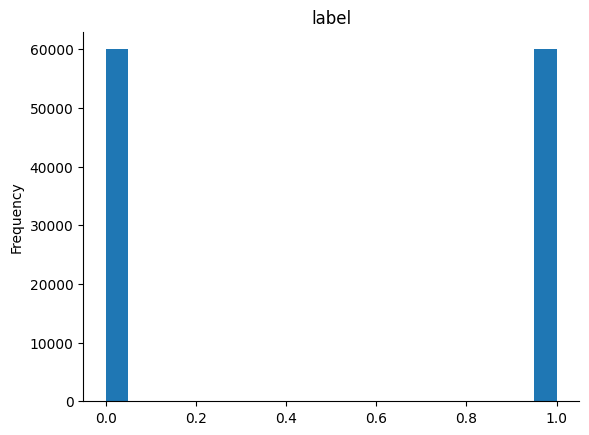

In [6]:
from matplotlib import pyplot as plt
df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
# @title 划分训练集和测试集
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# 划分训练集和测试集
train_df, test_df = train_test_split(df, test_size=0.2,shuffle=True, random_state=42)
print('train_df info')
print('test_df info')
print(train_df)
print(test_df)

train_df info
test_df info
        label                                             review
43852       1               乐乐的武汉之武汉步行街~[哈哈]我窃以为只比南京的夫子庙好了那么一丢丢~
21608       1        →_→//@最爱Cruise: 然后去医院医生给火柴包起一圈绷带出来就成棉签了[哈哈]
91972       0                                   午饭来不及吃，先垫下肚子。[泪]
78263       0  [汗]//@LimingX:[衰] //@万昊-百度: @cremer_xiao 想想办法吧...
73639       0                      昨天被人恶作剧了，表白什么的不是真的? [晕][晕][晕]
...       ...                                                ...
110268      0  谢谢！亲爱的 @逗豆芽儿 收到了你从三亚送来的礼物~ 喜欢咖啡的我自然地爱吃咖啡糖，其他三亚...
119879      0                     [衰]除了最后一张，几大主持都被黑了一遍~小编你是要闹哪样？
103694      0                                解散，彻底解散！！！[衰][衰][衰]
860         1  回复@薛晓棠:哎，我咋记得这提壶是牛奶的意思？不会真的让我提个壶逮谁浇谁吧，那叫浇朋友，我懂...
15795       1                         这么早回家，真是不可思议，这可是周六呀！！！[嘻嘻]

[95990 rows x 2 columns]
       label                                             review
47063      1  回复@沂蒙山区老母鸡:如何解决保鲜问题？ //@沂蒙山区老母鸡:我想办法给您快递好吗？[太开...
34050      1         幻想的吧，大中午的。 //@小树林s

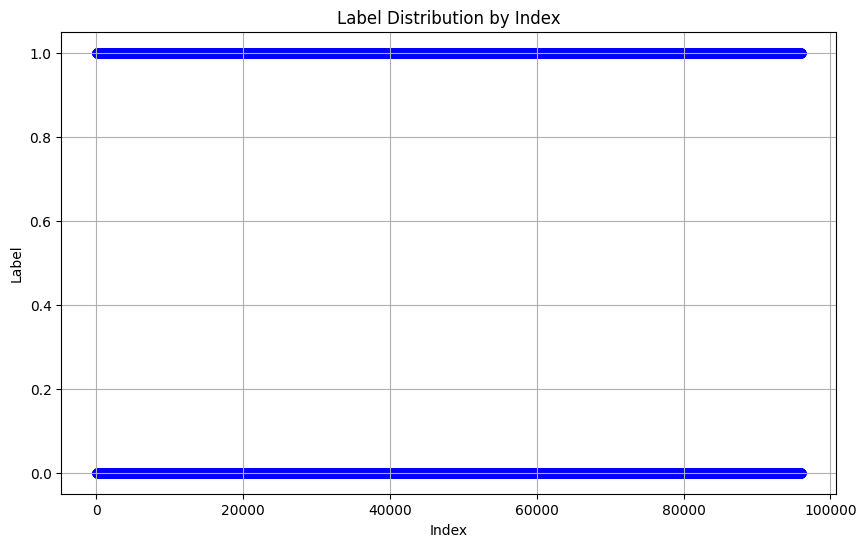

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
train_df_plt = train_df.copy()
train_df_plt['id'] = range(1, len(train_df_plt) + 1)
# 以 index 作为横轴，label 列作为纵轴进行散点图可视化
plt.figure(figsize=(10, 6))
plt.scatter(train_df_plt['id'], train_df_plt['label'], color='b')
plt.xlabel('Index')
plt.ylabel('Label')
plt.title('Label Distribution by Index')
plt.grid(True)
plt.show()

In [9]:
# @title 检查设备可用性 初始化分词器
# 检查是否有可用的 CUDA 设备
if torch.cuda.is_available():
    # 指定使用 cuda:1
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# 初始化分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

## 训练方法一

In [ ]:
# @title 创建数据集
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
# 创建类别到索引的映射
label_to_index = {label: idx for idx, label in enumerate(df['label'].unique())}
# 使用映射来更新标签
train_labels = [label_to_index[label] for label in train_df['label']]
test_labels = [label_to_index[label] for label in test_df['label']]
print(f'train_labels:{train_labels}')
print(f'test_labels:{test_labels}')
# 然后在创建数据集时使用这些更新后的标签
train_dataset = TextDataset(tokenizer, train_df['review'].tolist(), train_labels)
test_dataset = TextDataset(tokenizer, test_df['review'].tolist(), test_labels)


# 创建数据集 如果所有的标签都是数字 本部分也可以直接采用下面的两行
# train_dataset = TextDataset(tokenizer, train_df['text'].tolist(), train_df['label'].tolist())
# test_dataset = TextDataset(tokenizer, test_df['text'].tolist(), test_df['label'].tolist())


print(train_dataset)
print(test_dataset)

train_labels:[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,

In [ ]:
# @title 设定参数
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=len(df['label'].unique()))
model = model.to(device)# 将模型转移到对应的设备运行

# 定义训练参数
training_args = TrainingArguments(
    output_dir='GISchat-weibo-100k-fine-tuned-bert',
    num_train_epochs=1,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
    evaluation_strategy="steps",
    eval_steps=500,  # 每500步进行一次评估
    save_strategy = "steps",
    save_steps= 1000,
    # evaluation_strategy ="epoch",
    # save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id = "wsqstar/GISchat-weibo-100k-fine-tuned-bert"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# @title 训练
trainer.train()

trainer.evaluate()


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,No log,0.074877,0.980582,0.980559,0.969157,0.992232
1000,0.105300,0.039729,0.983915,0.983966,0.968438,1.000000
1500,0.105300,0.039707,0.983957,0.984007,0.968517,1.000000
2000,0.048600,0.044348,0.983957,0.984007,0.968517,1.000000
2500,0.048600,0.039072,0.984040,0.984089,0.968676,1.000000
3000,0.037600,0.036185,0.984040,0.984089,0.968676,1.000000


{'eval_loss': 0.03618502616882324,
 'eval_accuracy': 0.9840403366947246,
 'eval_f1': 0.9840887374849404,
 'eval_precision': 0.9686758812464219,
 'eval_recall': 1.0,
 'eval_runtime': 277.1632,
 'eval_samples_per_second': 86.584,
 'eval_steps_per_second': 1.353,
 'epoch': 1.0}

In [ ]:
# @title 保存模型到本地
# 保存模型到本地/或者，下面是远程的方式：这里需要提供自己的用户名和自己的repository(这里不需要自己手动新建，有自动建立的)
# output_dir = "wsqstar/GISChat-weibo-100k-fine-tuned-bert"
# # model.save_pretrained(output_dir)
# # tokenizer.save_pretrained(output_dir)
# pr

In [ ]:
# @title 上传
# trainer.push_to_hub()
repo_id = "GISChat-weibo-100k-fine-tuned-bert"
tokenizer.push_to_hub(repo_id)

README.md:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/wsqstar/GISchat-weibo-100k-fine-tuned-bert/commit/0d4b73a877e89a15feaa012cc635799805537ad7', commit_message='Upload tokenizer', commit_description='', oid='0d4b73a877e89a15feaa012cc635799805537ad7', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# !rm -rf /content/GISchat-weibo-100k-fine-tuned-bert/*

## 训练方法二

In [10]:
# ds来自前面的数据
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'review'],
        num_rows: 119988
    })
})

In [11]:
# 将训练集分割为新的训练集和验证集
split_ds = ds['train'].train_test_split(test_size=0.2, shuffle=True, seed=42)
# 访问新的训练集
new_train_ds = split_ds["train"]
# 访问新的验证集
new_val_ds = split_ds["test"]

split_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'review'],
        num_rows: 95990
    })
    test: Dataset({
        features: ['label', 'review'],
        num_rows: 23998
    })
})

In [12]:
# 获取 train 数据集中 label 字段的唯一值
train_unique_labels = split_ds['train'].unique('label')
print(f"Train dataset unique labels: {train_unique_labels}")

# 获取 test 数据集中 label 字段的唯一值
test_unique_labels = split_ds['test'].unique('label')
print(f"Test dataset unique labels: {test_unique_labels}")

Train dataset unique labels: [1, 0]
Test dataset unique labels: [1, 0]


In [13]:
from collections import Counter
from datasets import concatenate_datasets

# 合并训练、验证和测试集的标签
all_labels = split_ds['train']['label'] + split_ds['test']['label']

# 计算标签的分布
label_distribution = Counter(all_labels)

# 打印标签分布
print(label_distribution)

Counter({0: 59995, 1: 59993})


In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")


def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True)


tokenized_datasets = split_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/23998 [00:00<?, ? examples/s]

In [15]:
# small_train_dataset = tokenized_datasets["train"]
# small_eval_dataset = tokenized_datasets["test"]

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(3000))

In [16]:
from transformers import AutoModelForSequenceClassification
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=num_labels)
print(num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2


In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments("GISchat-weibo-100k-fine-tuned-bert", save_strategy="steps", push_to_hub=True)

In [18]:
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")

In [19]:
# 定义计算评估指标的函数
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    # confusion_matrix = confusion_matrix_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

In [20]:
from transformers import TrainingArguments, Trainer

# 设置训练参数
training_args = TrainingArguments(
    output_dir="GISchat-weibo-100k-fine-tuned-bert",
    num_train_epochs=1,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    # evaluation_strategy="steps",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    logging_dir='./logs',
    logging_steps=200,
    push_to_hub=True,
    hub_model_id="wsqstar/GISchat-weibo-100k-fine-tuned-bert"  # 替换为你的用户名和模型名称
)

In [21]:
from transformers import set_seed

# set_seed(42)  # 确保这是一个有效的整数

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,No log,0.657286,0.606000
200,0.647000,0.244656,0.950667
300,0.647000,0.091444,0.980667
400,0.127600,0.060919,0.984333
500,0.127600,0.060654,0.984333
600,0.092100,0.105293,0.980000
700,0.092100,0.048722,0.985333
800,0.088500,0.052304,0.985333
900,0.088500,0.048417,0.986000
1000,0.057900,0.054915,0.985000


TrainOutput(global_step=1250, training_loss=0.1721352954864502, metrics={'train_runtime': 2161.3292, 'train_samples_per_second': 4.627, 'train_steps_per_second': 0.578, 'total_flos': 2631110553600000.0, 'train_loss': 0.1721352954864502, 'epoch': 1.0})

将模型以及tokenizer推送到hugging face


In [23]:
trainer.push_to_hub()


CommitInfo(commit_url='https://huggingface.co/wsqstar/GISchat-weibo-100k-fine-tuned-bert/commit/769a5a8e71c305f100340ef50e54ad0c6bd8d2ce', commit_message='End of training', commit_description='', oid='769a5a8e71c305f100340ef50e54ad0c6bd8d2ce', pr_url=None, pr_revision=None, pr_num=None)

In [24]:

repo_name = 'GISchat-weibo-100k-fine-tuned-bert'
tokenizer.push_to_hub(repo_name)


README.md:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/wsqstar/GISchat-weibo-100k-fine-tuned-bert/commit/e8b23c802050281c1a8b8bd20f6d3c271f98fc89', commit_message='Upload tokenizer', commit_description='', oid='e8b23c802050281c1a8b8bd20f6d3c271f98fc89', pr_url=None, pr_revision=None, pr_num=None)

# 测试
# https://huggingface.co/wsqstar/GISchat-weibo-100k-fine-tuned-bert

In [11]:
# @title 查看bert-base-chinese
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# 加载预训练的BERT模型和分词器
model_name = 'bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 假设有2个类别

# 准备要分类的文本
texts = ["姑娘都羡慕你呢…还有招财猫高兴…", "好冷啊", "好害怕"]

# 对文本进行tokenize并转换为模型输入格式
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# 使用模型进行推理
with torch.no_grad():
    outputs = model(**inputs)

# 获取预测结果
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)

# 输出预测类别
for i, text in enumerate(texts):
    print(f"文本: {text}")
    print(f"预测类别: {predictions[i].item()}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


文本: 姑娘都羡慕你呢…还有招财猫高兴…
预测类别: 1
文本: 好冷啊
预测类别: 1
文本: 好害怕
预测类别: 0


In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [25]:
# @title 尝试使用
# Load model directly
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# 加载模型和tokenizer
model_name = 'wsqstar/GISchat-weibo-100k-fine-tuned-bert'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 有2个类别

# 检查模型是否正确加载
print(model)


model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [26]:

round = 1
while round <= 2:
    print(f'round:{round}')

    # 准备要分类的文本
    texts = ["真的好羡慕", "真的好讨厌", "不知道为什么有点伤心","这件事情好难以置信"]

    # 对文本进行tokenize并转换为模型输入格式
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    # 使用模型进行推理
    with torch.no_grad():
        outputs = model(**inputs)

    # 获取预测结果
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # 输出预测类别
    for i, text in enumerate(texts):
        print(f"文本: {text}")
        print(f"预测类别: {predictions[i].item()}")

    round += 1

round:1
文本: 真的好羡慕
预测类别: 1
文本: 真的好讨厌
预测类别: 0
文本: 不知道为什么有点伤心
预测类别: 0
文本: 这件事情好难以置信
预测类别: 0
round:2
文本: 真的好羡慕
预测类别: 1
文本: 真的好讨厌
预测类别: 0
文本: 不知道为什么有点伤心
预测类别: 0
文本: 这件事情好难以置信
预测类别: 0


In [51]:
import torch.nn.functional as F

# 应用softmax函数
probabilities = F.softmax(logits, dim=-1)

# 获取概率最高的类别索引
predictions = torch.argmax(probabilities, dim=-1)

# 输出预测类别及其概率
for i, text in enumerate(texts):
    print(f"文本: {text}")
    predicted_index = predictions[i].item()
    print(f"预测类别索引: {predicted_index}")
    print(f"预测类别概率: {probabilities[i, predicted_index].item()}")

文本: 真的好羡慕
预测类别索引: 1
预测类别概率: 0.9278697967529297
文本: 真的好讨厌
预测类别索引: 1
预测类别概率: 0.7676805257797241
文本: 不知道为什么有点伤心
预测类别索引: 0
预测类别概率: 0.7125946879386902
文本: 这件事情好难以置信
预测类别索引: 0
预测类别概率: 0.575763463973999
